# **Shells**

## Step 1 : Mesh

In [10]:
from dewloosh.mesh.rgrid import gridQ4
import numpy as np

size = Lx, Ly = (20, 5)
shape = nx, ny = (40, 20)

gridparams = {
    'size': size,
    'shape': shape,
    'origo': (0, 0),
    'start': 0
}

coords2d, topo = gridQ4(**gridparams)
coords = np.zeros((coords2d.shape[0], 3))
coords[:, :2] = coords2d[:, :]


## Step 2 : Material

In [11]:
from sigmaepsilon.model import MindlinPlate as Plate, Membrane

membrane = {
    '0' : {
        'hooke' : Membrane.Hooke(E=12000, nu=0.2),
        'angle' : 0., 
        'thickness' : 0.25
        },
    }
A = Membrane.from_dict(membrane).stiffness_matrix()

plate = {
    '0' : {
        'hooke' : Plate.Hooke(E=12000, nu=0.2),
        'angle' : 0., 
        'thickness' : 0.25
        },
    }
D = Plate.from_dict(plate).stiffness_matrix()

## Step 3 : Boundary Conditions

In [12]:
# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 6), dtype=bool)
fixity[ebcinds, :] = True

# unit vertical load at (Lx, Ly)
F = 10
loads = np.zeros((coords.shape[0], 6))

cond = (coords[:, 0] > (Lx-(1e-12))) & (coords[:, 1] > (Ly-(1e-12)))
nbcinds = np.where(cond)[0]
loads[nbcinds, 2] = -F

cond = (coords[:, 0] > (Lx-(1e-12))) & (coords[:, 1] < (1e-12))
nbcinds = np.where(cond)[0]
loads[nbcinds, 2] = F


## Step 4 : Assembly and Solution

In [13]:
from sigmaepsilon import Structure, PointData
from sigmaepsilon.mesh.space import StandardFrame
from sigmaepsilon import Structure, FemMesh
from sigmaepsilon.fem.cells import Q4M, Q4P
from dewloosh.math.array import repeat

GlobalFrame = StandardFrame(dim=3)

# points
points = PointData(coords=coords, frame=GlobalFrame,
                   loads=loads, fixity=fixity)

# set up mesh and structure
mesh = FemMesh(points, frame=GlobalFrame)

# cells
frames = repeat(GlobalFrame.show(), topo.shape[0])
mesh['membrane'] = FemMesh(Q4M(topo=topo, frames=frames), model=A)
mesh['plate'] = FemMesh(Q4P(topo=topo, frames=frames), model=D)

structure = Structure(mesh=mesh)


In [14]:
mesh.topology().shape, [cb.topology().shape for cb in mesh.cellblocks()]

((1600, 4), [(800, 4), (800, 4)])

In [15]:
structure.linsolve()
dofsol = structure.nodal_dof_solution()
structure.mesh.pointdata['x'] = coords + dofsol[:, :3]

## Step 5 : Plotting

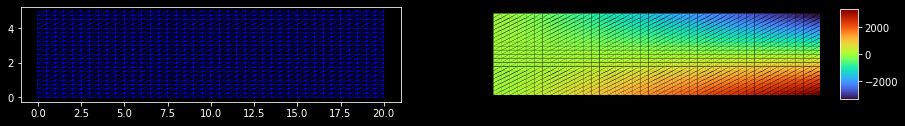

In [16]:
%matplotlib inline
from dewloosh.mesh.topo.tr import Q4_to_T3
from dewloosh.mesh.tri.triang import triangulate
from dewloosh.mesh.tri.triplot import triplot
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.style.use('dark_background')

points, triangles = Q4_to_T3(structure.mesh.coords(), topo)
triobj = triangulate(points=points[:, :2], triangles=triangles)[-1]

fig = plt.figure(figsize=(15, 4))  # in inches
fig.patch.set_facecolor('black')
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
triplot(triobj, ax=ax1, fig=fig)
triplot(triobj, ax=ax2, fig=fig,
        data=dofsol[:, 2], cmap='turbo', axis='off')
